<a href="https://colab.research.google.com/github/Cinema-Paradiso/DL/blob/main/conda_pytorch_p27_05_transferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* 참조 깃헙
    * https://github.com/GunhoChoi/PyTorch-FastCampus/blob/master/07_Transfer_Learning/0_Pretrained_Basic/Transfer_Learning.ipynb
    * 모델 하나로 만들자.
    * 01_pretrainedVGG_media_v4
* MediaClassifier_a_VGG
    * 다른 네트워크의 base 가 되도록 만들기

## 1. Settings
### 1) Important required libraries

In [ ]:
#깃헙 주소 : https://github.com/Cinema-Paradiso/DL/blob/main/05_transferLearning.ipynb

In [17]:
#교수님의 utils.py 파일을 실행 파일에 복사/붙여넣기 하였습니다.
#import utils로 불러오고 싶었으나, 오류가 나서 위와같은 방법으로 해결했습니다.

# -*- coding: utf-8 -*-
import numpy as np
import torch
import torch.utils.data as data
from torch.autograd import Variable

def func(num):
    print(num)
# ================================================================
# Compute correct ratio (Recall)
# ================================================================
# * 주의! dropout or batch normalization 을 적용한 모델이라면, 
#  반드시 model.eval() <--> model.train() 
#  evaluation mode 로 변경한 후 함수 호출할 것
# * 호출 방법
#  print(utils.ComputeCorr(test_batch, model))
def ComputeCorr(i_data_batch, i_model):  
    correct = 0
    total = 0
    for img, label in i_data_batch:
        torch.no_grad()
        #img = Variable(imgs, volatile=True).cuda()
        img = Variable(img).cuda()  # back prop. 안하고, forward prop. 만 하겠다.
        label = Variable(label).cuda()
        
        output = i_model(img)
        _, output_index = torch.max(output, 1)
        
        total += label.size(0)
        correct += (output_index == label).sum().float()
    tmp = 100*correct/total
    tmp = (tmp.cpu()).data.numpy()
    #print("correct: %.2f" %tmp)
    
    return tmp

# ========================================================================
# Compute Pred, 덤으로 true, probability
# ========================================================================
def my_softmax(arr):
    # 합
    sum = 0.0
    for i in range(len(arr)):
        sum = sum + np.exp(arr[i])
    
    for i in range(len(arr)):
        arr[i] = np.exp(arr[i]) / sum
    return arr

# return 값 del 하길 권장함
def ComputePred(i_batch, i_model, i_batch_size=32):
    # 1. 전체 길이 계산
    n = 0
    for i, [imgs, _] in enumerate(i_batch):
        n += len(imgs) 
        
    # 2. pred, true
    pred_1d = np.ndarray(n, dtype=int)
    label_1d = np.ndarray(n, dtype=int)
    probability_1d = np.ndarray(n, dtype=float)
    for i, [imgs, labels] in enumerate(i_batch):
        torch.no_grad()
        x = Variable(imgs).cuda()  ## back prop. 안하고, forward prop. 만 하겠다.
        y_ = Variable(labels).cuda()
        
        output = i_model(x)
        _, output_index = torch.max(output, 1)
    
        # 1) pred
        output_index_cpu = (output_index.data.cpu()).numpy()  #cpu()
        y_cpu = (y_.data.cpu()).numpy()  #cpu()
        
        size = len(x)
#         s = (i*i_batch_size)
#         e = s + size    
        for k in range(size):
            pred_1d[i*i_batch_size + k] = int(output_index_cpu[k])
            label_1d[i*i_batch_size + k] = int(y_cpu[k])
        
        # 2) probability
        prob_arr = (output.cpu()).data.numpy()
        for k in range(size):
            prob = my_softmax(prob_arr[k])
            idx = pred_1d[i*i_batch_size + k]
            probability_1d[i*i_batch_size + k] = prob[idx]
        
    return pred_1d, label_1d, probability_1d  

# total probability 리턴하자. class 개수 필요
def ComputePredProb(i_batch, i_model, i_classes, i_batch_size=32):
    # 1. 전체 길이 계산
    n = 0
    for i, [imgs, _] in enumerate(i_batch):
        n += len(imgs) 
        
    nclass = len(i_classes)
    
    # 2. pred, true
    pred_1d = np.ndarray(n, dtype=int)    # 모든 n개 영상에 대한 prediction
    label_1d = np.ndarray(n, dtype=int)   # 모든 n개 영상에 대한 true label
    probability_1d = np.ndarray(n, dtype=float)
    probability_total_2d = np.ndarray((n, nclass), dtype=float)  # 모든 n개 영상에 대한 모든 클래스의 probability (n x nclass)
    for i, [imgs, labels] in enumerate(i_batch):
        torch.no_grad()
        x = Variable(imgs).cuda()  ## back prop. 안하고, forward prop. 만 하겠다.
        y_ = Variable(labels).cuda()
        
        output = i_model(x)
        _, output_index = torch.max(output, 1)
    
        # 1) pred
        output_index_cpu = (output_index.data.cpu()).numpy()  #cpu()
        y_cpu = (y_.data.cpu()).numpy()  #cpu()
        
        size = len(x)
#         s = (i*i_batch_size)
#         e = s + size    
        for k in range(size):
            pred_1d[i*i_batch_size + k] = int(output_index_cpu[k])
            label_1d[i*i_batch_size + k] = int(y_cpu[k])
        
        # 2) probability
        prob_arr = (output.cpu()).data.numpy()
        for k in range(size):
            prob = my_softmax(prob_arr[k])
            idx = pred_1d[i*i_batch_size + k]
            probability_1d[i*i_batch_size + k] = prob[idx]
                                      
            #print(prob.size())
            probability_total_2d[i*i_batch_size + k, :] = prob  # (n x nclass)                                      
        
    return pred_1d, label_1d, probability_1d, probability_total_2d
    
# ========================================================================
# Confusion matrix 로 accuracy, precision, recal, F1 score 계산 및 출력
# ========================================================================
def EvaluateClassifier(i_batch, i_model, i_classes, i_batch_size=32):
    # --- 1. Confusion matrix 그리기 ---
    # 1) pred, true 배열 구하기
    # 전체 길이 계산
    n = 0
    for i, [imgs, _] in enumerate(i_batch):
        n += len(imgs)    
    
    pred_1d, label_1d, prob_1d, prob_2d = ComputePredProb(i_batch, i_model, i_classes, i_batch_size)
    
    # 2) confusion matrix 계산
    #print("size of pred: %d, true: %d" %(len(pred_1d), len(label_1d)))
    cnf_mat = confusion_matrix(label_1d, pred_1d)
    #del pred_1d, label_1d

    plt.figure()
    plot_confusion_matrix(cnf_mat, classes=i_classes, normalize=True, title='Normalized confusion matrix')
    plt.show()

    plt.figure()
    plot_confusion_matrix(cnf_mat, classes=i_classes, title='Confusion matrix, without normalization')
    plt.show()

    # --- 2. Accr, F1, Precision, Recall ---
    matric4classifer(cnf_mat, i_classes)
    
    # --- 3. mAP(mean average precision ---
    # aps: 각 클래스의 AP
    # o_mAP: 모든 AP의 평균
    o_mAP, aps = mAP(prob_2d, label_1d, i_classes)
    
    # --- 4. imAP(image mean average precision) ---
    o_imAP, iaps = imAP(prob_2d, label_1d)
    
    return pred_1d, label_1d, prob_1d
    
# ========================================================================
# 한 영상에 대해 n회 voting 방식으로 평가 (EvaluateClassifier와 유사)
# ========================================================================
# * EvaluateClassifier 참조
# * random 하게 crop 되는 특성 상, +-2% 정도 정확도가 달라질 수
# is_weight: weight voting 방식 여부
def EvaluateClassifierVot(i_batch, i_model, i_classes, i_n_vot=2, i_batch_size=32, is_weight=False):
    # 1. 전체 길이 계산
    n = 0
    for i, [imgs, _] in enumerate(i_batch):
        n += len(imgs) 
    
    # 2. n 회 forwarding -> pred, true, probability
    n_vot = i_n_vot     # 한 이미지에서 자를 영역 개수(voting 인원)
    #  1) 배열 할당    
    pred_2d = np.ndarray((n_vot, n), dtype=int)   # predicted label. (n_vot x n) = (# of voting x # of images)
    label_2d = np.ndarray((n_vot, n), dtype=int)  # true label. (n_vot x n) = (# of voting x # of images)
    prob_2d = np.ndarray((n_vot, n), dtype=float) # probability of the only predicted label
    #  2) predict
    for v in range(n_vot):
        print("%d/%d.." %(v, n_vot)),
        pred_2d[v, :], label_2d[v, :], prob_2d[v, :] = ComputePred(i_batch, i_model, i_batch_size)
    print("done")
    
    # 3. voting 2 -> pred_vot
    nclass = len(i_classes)
    vot_pred = np.ndarray(n, dtype=int)
    vot_label = np.ndarray(n, dtype=int)
    vot_prob = np.ndarray(n, dtype=float)      # 여기!!
    vote = np.ndarray(nclass, dtype=float)
    vcnt = np.ndarray(nclass, dtype=int)   # 획득한 표 개수
    correct = 0
    for i in range(n):
        # 한 영상에 대한 n_vot 개 vote 결과
        vote[:] = 0
        vcnt[:] = 0
        for v in range(n_vot):
            idx = pred_2d[v, i]
            if (is_weight==False):
                vote[idx] += 1
            else:
                vote[idx] += prob_2d[v, i]
            vcnt[idx] += 1
        vot_pred[i] = np.argmax(vote)
        vot_label[i] = label_2d[0, i]
        
        # n_vot 로 나눠야 0~1
        #print(vote)
        vot_prob[i] = vote[vot_pred[i]] / (float)(vcnt[idx])    #np.asarray(vote) / n_vot    # 여기!!
        
        correct += (vot_pred[i]==vot_label[i])
        
    del pred_2d, label_2d, prob_2d, vote
    
    # 4. 결과
    #  1) pred_vot, pred_true -> corr(recall)
    correct = float(correct) / float(n)
    print("Correct: %.2f" %correct)
    
    #  2) pred_vot, pred_true -> evaluate
    # evaluate (1) confusion matrix
    cnf_mat = confusion_matrix(vot_label, vot_pred)

    plt.figure()
    plot_confusion_matrix(cnf_mat, classes=i_classes, normalize=True, title='Normalized confusion matrix')
    plt.show()

    plt.figure()
    plot_confusion_matrix(cnf_mat, classes=i_classes, title='Confusion matrix, without normalization')
    plt.show()
    # evaluate (2) Accr, F1, Precision, Recall 
    matric4classifer(cnf_mat, i_classes)    
    
    #del vot_pred, vot_label
    return vot_pred, vot_label, vot_prob
    
# ========================================================================
# 한 영상의 n회 predicted probabilities 를 sum 하여 평가 (EvaluateClassifierVot와 유사)
# ========================================================================
# * EvaluateClassifierVot 참조
# * random 하게 crop 되는 특성 상, +-2% 정도 정확도가 달라질 수
def EvaluateClassifierWeightedSum(i_batch, i_model, i_classes, i_n_vot=2, i_batch_size=32):
    # 1. 전체 길이 계산
    n = 0
    for i, [imgs, _] in enumerate(i_batch):
        n += len(imgs) 
    
    nclass = len(i_classes)
    
    # 2. n 회 forwarding -> pred, true, probability
    n_vot = i_n_vot     # 한 이미지에서 자를 영역 개수(voting 인원)
    #  1) 배열 할당    
    vot_pred = np.ndarray(n, dtype=int)    # final pred to be returned (# of images)
    vot_label = np.ndarray(n, dtype=int)
    vot_prob = np.ndarray(n, dtype=float)
    sum_prob_total = np.ndarray((n, nclass), dtype=float) # 모든 n개 영상에 대한 모든 클래스의 probability. (n x nclass) = (# of images x # of classes)
    
    #  2) predict
    sum_prob_total[:] = 0
    for v in range(n_vot):
        print("%d/%d.." %(v, n_vot)),
        #pred_2d[v, :], label_2d[v, :], prob_2d[v, :] = ComputePred(i_batch, i_model, i_batch_size)
        # 모든 n개 영상에 대한 모든 클래스의 probability (n x nclass)
        _, vot_label, _, prob_total_2d = ComputePredProb(i_batch, i_model, i_classes, i_batch_size)
        sum_prob_total += prob_total_2d
    print("done")
    
    # 3) avg of the softmax
    sum_prob_total /= (float)(n_vot)
    
    # 4) 3을 이용해 결정
    correct = 0.0
    for i in range(n):
        vot_pred[i] = np.argmax(sum_prob_total[i])
        idx = vot_pred[i]
        vot_prob[i] = sum_prob_total[i][idx]
        
        correct += (vot_pred[i]==vot_label[i])
    
    # 결과
    # 1) correct
    correct = float(correct) / float(n)
    print("Correct: %.2f" %correct)
    
    #  2) pred_vot, pred_true -> evaluate
    # evaluate (1) confusion matrix
    cnf_mat = confusion_matrix(vot_label, vot_pred)

    plt.figure()
    plot_confusion_matrix(cnf_mat, classes=i_classes, normalize=True, title='Normalized confusion matrix')
    plt.show()

    plt.figure()
    plot_confusion_matrix(cnf_mat, classes=i_classes, title='Confusion matrix, without normalization')
    plt.show()
    
    # evaluate (2) Accr, F1, Precision, Recall 
    matric4classifer(cnf_mat, i_classes)    
    print("\n")
    
    #del vot_pred, vot_label
    return vot_pred, vot_label, vot_prob

import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# ========================================================================
# Data 에 따라 basic or (weighted) voting 방식 평가 해주기
# ========================================================================
# * EvaluateClassifier(Vot) 함수 사용함
# * 굳이 image directory 를 넣은이유? voting 은 transform 이 달라요. 랜덤 크롭해야해서
# * img_dir: text할 이미지 경로
# * Mode: 평가방식. {None, "WSum", "WVot", "Vot"}
# * 호출
# img_dir = "../../images/painting_dataset/real_artwork_divided_shffl_4K/Test"
# utils.EvalData(img_dir, model, "WSum", batch_size, 5)
def EvalData(i_img_dir, i_model, Mode=None, 
             i_batch_size=32, i_n_vot=2, i_imgsize=256):
    i_model.eval()
    if (Mode==None):
        my_data = dset.ImageFolder(i_img_dir, transforms.Compose([        
                transforms.CenterCrop(size=i_imgsize),
            
                transforms.Scale(i_imgsize),
                transforms.ToTensor()
                ]))
        batch = data.DataLoader(my_data, batch_size=i_batch_size,
                                    shuffle=False, num_workers=2)
        print("data len: %d" %my_data.__len__())
        print("--- [Data] %s ---" %i_img_dir)
        print("--- [평가방식] Basic ---")
        EvaluateClassifier(batch, i_model, my_data.classes, i_batch_size)
    else:
        my_data = dset.ImageFolder(i_img_dir, transforms.Compose([    
                    transforms.CenterCrop(i_imgsize*2),  
                    transforms.RandomCrop(i_imgsize),  

                    transforms.Scale(i_imgsize),
                    transforms.ToTensor()
                    ]))
        batch = data.DataLoader(my_data, batch_size=i_batch_size,
                                    shuffle=False, num_workers=2)
        print("data len: %d" %my_data.__len__())
        print("--- [Data] %s ---" %i_img_dir)
        
        if (Mode=="WSum"):
            print("--- [평가방식] Weighted sum (직접선거) ---")
            EvaluateClassifierWeightedSum(batch, i_model, my_data.classes, i_n_vot, i_batch_size) 
        elif (Mode=="WVot"):
            print("--- [평가방식] Weighted voting (가중치 간접선거) ---")
            EvaluateClassifierVot(batch, i_model, my_data.classes, i_n_vot, i_batch_size, True)
        elif (Mode=="Vot"):
            print("--- [평가방식] Voting (간접선거) ---")
            EvaluateClassifierVot(batch, i_model, my_data.classes, i_n_vot, i_batch_size, False)
        else:
            print("Wrong Mode input.")
            print("The Mode must be only one of {None, \"WSum\", \"WVot\", \"Vot\"}")

import os
# ========================================================================
# 논문 별 결과 그래프 그리기
# ========================================================================
# * i_img_dir: 주 클래스 내에 논문별로 폴더가 있어야 함
# * i_pred: i_img_dir 의 모든 영상에 대한 pred
# * i_label: i_img_dir 의 모든 영상에 대한 label
# * i_prob: i_img_dir 의 모든 영상에 대한 probability
# * model 이 필요하지 않음
# vot에 대한 고려 없음 (i_prob 에 대한 고려해서 코딩 다시 해야 함)
def VisPaper(i_img_dir, i_classes, i_pred, i_label, i_prob):
    print("Category \t| paper \t\t| True/False \t| recall| E(true_prob) | E(prob)")
    
    cnt = 0  
    for i, category in enumerate(i_classes):   # 카테고리 폴더 접근 
        print("%s \t\t|" %category)
        total_true = []
        total_false = []
        total_recall = []
        total_e_true_prob = []
        total_e_prob = []
        npaper = 0

        paperlist_path = i_img_dir + "/" + category      # paper list 가 있는 path
        paperlist = sorted(os.listdir(paperlist_path))
        for paper in paperlist:   # 논문 폴더 접근
            print("\t\t %s" %paper),
            cnt_true = 0
            cnt_false = 0
            sum_true_prob = 0.0
            sum_prob = 0.0  # avg(I*p)   I: 1(true) or -1(false)

            paper_path = paperlist_path + "/" + paper
            for f in os.listdir(paper_path):    # 이미지 파일 접근
    #             if os.path.splitext(f)[1].lower() not in valid_exts:
    #                 continue               
                if (i_pred[cnt]==i_label[cnt]):
                    cnt_true = cnt_true + 1
                    sum_true_prob = sum_true_prob + i_prob[cnt]
                    sum_prob = sum_prob + i_prob[cnt]
                else:
                    cnt_false = cnt_false + 1
                    sum_prob = sum_prob - i_prob[cnt]

                cnt = cnt + 1
            
            recall = (float)(cnt_true)/(float)(cnt_true+cnt_false)
            if (cnt_true==0):
                e_true_prob = 0.0
            else:
                e_true_prob = sum_true_prob/(float)(cnt_true)
            e_prob = sum_prob / (float)(cnt_true+cnt_false)
            print("\t T%d/F%d \t\t %.2f \t %.2f \t %.2f" %(cnt_true, cnt_false, # # of true prediction & false prediction
                                                   recall,  # recall
                                                   e_true_prob,
                                                   e_prob) 
                 )

            total_true.append(cnt_true)
            total_false.append(cnt_false)
            total_recall.append(recall)
            total_e_true_prob.append(e_true_prob)
            total_e_prob.append(e_prob)
            npaper = npaper + 1

        # --- 분할 막대 차트 ---
        Y = range(npaper)
        plt.barh(Y, total_true, label='true predicted', color='b', height=0.3)
        plt.barh(Y, total_false, color='r', label='false predicted', left=total_true, height=0.3)

        plt.ylabel('Papers\nyears.author')
        plt.yticks(Y, paperlist)

        plt.grid()
        plt.legend()   # 범례
        plt.xlabel('# of true/false predicted results')
        plt.title('Synthesized artworks experiments (%s)' %category)

        plt.show()
        
        # --- Expectation of Probability ---
        plt.barh(Y, total_e_prob, color=(0.0, 0.0, 0.0), height=0.3)
        plt.legend()   # 범례    
        plt.ylabel('Papers\nyears.author')
        plt.yticks(Y, paperlist)
        plt.xlabel('avg. of predicted probability')
        plt.title('Avg. of \'True/False\' x \'Probability\' (%s)' %category)
        plt.show()

        # --- true ratio (Recall) ---
        plt.barh(Y, total_recall, label='true ratio', color=(0.0, 0.0, 0.0), height=0.3)
        plt.legend()   # 범례    
        plt.ylabel('Papers\nyears.author')
        plt.yticks(Y, paperlist)
        plt.xlabel('true ratio')
        plt.title('Recall (%s)' %category)
        plt.show()

        #X = range(npaper)
        #plt.bar(X, total_true, color='b')
        #plt.bar(X, total_false, color='r', bottom=total_true)
        #plt.xticks(X, total_recall)
        #plt.show()
        
        # --- Expectation of True Probability ---
        plt.barh(Y, total_e_true_prob, color=(0.0, 0.0, 0.0), height=0.3)
        plt.legend()   # 범례    
        plt.ylabel('Papers\nyears.author')
        plt.yticks(Y, paperlist)
        plt.xlabel('expectation of true probability')
        plt.title('Expectation of True Probability (%s)' %category)
        plt.show()
    print(cnt)
    
# ========================================================================
# '논문' Data 에 대해 basic or (weighted) voting 방식 평가 해주기
# ========================================================================
# * EvalData() 와 비슷
# * EvaluateClassifier(Vot) 함수 사용함
# * 굳이 image directory 를 넣은이유? voting 은 transform 이 달라요. 랜덤 크롭해야해서
# * img_dir: text할 이미지 경로
# * Mode: 평가방식. {None, "WSum", "WVot", "Vot"}
def EvalPaper(i_img_dir, i_model, Mode=None, 
              i_batch_size=32, i_n_vot=2, i_imgsize=256, 
              is_show_img=False):
    i_model.eval()
    if (Mode==None):
        # 0. 데이터 로드
        my_data = dset.ImageFolder(i_img_dir, transforms.Compose([        
                transforms.CenterCrop(size=i_imgsize),
            
                transforms.Scale(i_imgsize),
                transforms.ToTensor()
                ]))
        batch = data.DataLoader(my_data, batch_size=i_batch_size,
                                    shuffle=False, num_workers=2)
        print("data len: %d" %my_data.__len__())
        print("--- [Data] %s ---" %i_img_dir)
        print("--- [평가방식] Basic ---")
        
        # 1. 평가
        pred, label, prob = EvaluateClassifier(batch, i_model, my_data.classes, i_batch_size)
        
        # 2. 논문 별 결과 그래프 그리기
        VisPaper(i_img_dir, my_data.classes, pred, label, prob)
    else:
        # 0. 데이터 로드
        my_data = dset.ImageFolder(i_img_dir, transforms.Compose([    
                    transforms.CenterCrop(i_imgsize*2),  
                    transforms.RandomCrop(i_imgsize),  

                    transforms.Scale(i_imgsize),
                    transforms.ToTensor()
                    ]))
        batch = data.DataLoader(my_data, batch_size=i_batch_size,
                                    shuffle=False, num_workers=2)
        print("data len: %d" %my_data.__len__())
        print("--- [Data] %s ---" %i_img_dir)
        
        if (Mode=="WSum"):
            print("--- [평가방식] Weighted sum (직접선거) ---")
            # 1. 평가
            pred, label, prob = EvaluateClassifierWeightedSum(batch, i_model, my_data.classes, i_n_vot, i_batch_size) 
        elif (Mode=="WVot"):
            print("--- [평가방식] Weighted voting (가중치 간접선거) ---")
            pred, label, prob = EvaluateClassifierVot(batch, i_model, my_data.classes, i_n_vot, i_batch_size, True)
        elif (Mode=="Vot"):
            print("--- [평가방식] Voting (간접선거) ---")
            pred, label, prob = EvaluateClassifierVot(batch, i_model, my_data.classes, i_n_vot, i_batch_size, False)
        else:
            print("Wrong Mode input.")
            print("The Mode must be only one of {None, \"WSum\", \"WVot\", \"Vot\"}")
            return
        
        # 2. 논문 별 결과 그래프 그리기
        VisPaper(i_img_dir, my_data.classes, pred, label, prob)
        
    # 3. is_show_img
    if (is_show_img):
        cnt = 0
        for imgs, labels in batch:
            for i in range(len(imgs)):
                img = transforms.ToPILImage()(imgs[i])
                #plt.title("true: %s, pred: %s" %(my_data.classes[label[cnt]], my_data.classes[pred[cnt]]))
                curr_y = label[cnt]
                curr_pred = pred[cnt]
                curr_prob = prob[cnt]
                plt.title("Pred: %d(%s) %.2f / True: %d(%s)" %(curr_pred, my_data.classes[curr_pred], curr_prob*100.0,
                                                               curr_y, my_data.classes[curr_y]))
                plt.imshow(img)
                plt.show()
                cnt = cnt + 1
                
# ========================================================================
# Confusion matrix 로 accuracy, precision, recal, F1 score 계산 및 출력
# ========================================================================
def matric4classifer(cm, classes):
    n = len(classes)
    acc = np.ndarray((n), dtype=float)
    pre = np.ndarray((n), dtype=float)
    rec = np.ndarray((n), dtype=float)
    f1 = np.ndarray((n), dtype=float)

    '''
    TP: cm[i, i]
    FP: cm[:i-1, i] + cm[i+1:, i]
    FN: cm[i, :i-1] + cm[i, i+1:]
    TN: cm[:i-1, :i-1] + cm[i+1:, i+1:]
    '''
    print("\t acc  |\t pre  |\t rec  |\t f1")
    # 각 클래스마다
    for i, c in enumerate(classes):
        # 1. Accuracy = (TP+TN) / (TP+FP+FN+TN)
        if (i-1<0):
            tn1 = 0
        else:
            tn1 = np.sum(cm[:i, :i])   # [:i] '0 ~ i-1' 까지
            
        if (i+1>=n):
            tn2 = 0
        else:
            tn2 = np.sum(cm[i+1:, i+1:])  # [i:] 'i~끝' 까지
            
        acc[i] = float(cm[i, i] + tn1 + tn2) / float(np.sum(cm[:, :]))
        
        # 2. Precision = TP / (TP+FP)
        pre[i] = float(cm[i, i]) / float(np.sum(cm[:, i]))
        # 3. Recall = TP / (TP+FN)
        rec[i] = float(cm[i, i]) / float(np.sum(cm[i, :]))
        # 4. F1 Score = 2 * (precision*recall) / (precision+recall)
        if (float(pre[i] + rec[i])==0):
            f1[i] = 0.0
        else:
            f1[i] = 2.0 * float(pre[i] * rec[i]) / float(pre[i] + rec[i])
        
        print(" %s: %.2f |\t %.2f |\t %.2f |\t %.2f" % (c, acc[i], pre[i], rec[i], f1[i]))
    
    # total matric
    total_acc = np.average(acc)
    total_pre = np.average(pre)
    total_rec = np.average(rec)
    total_f1 = np.average(f1)

    print("*accuracy: %.2f, precision: %.2f, recall: %.2f, *f1 score: %.2f" %(total_acc, total_pre, total_rec, total_f1))
    
    del acc, pre, rec, f1

# indicator. i_classidx 번째 카테고리인지 아닌지 0 or 1 로 표시하는 배열 생성 후 리턴
#   i_true: true label (n)
#   i_classidx: 특정 클래스 아이디
def GetDelta(i_true, i_classidx):
    # delta: indicator (n). 
    delta = np.zeros(len(i_true))
    for i, label in enumerate(i_true):
        if label==i_classidx:
            delta[i] = 1
    return delta

# i-th class의 P@k(i)
#   i_delta: indicator. i 번째 카테고리인지 아닌지
def P(i_delta, k):
    n = len(i_delta)
    cnt = 0
    for i in range(0, k+1):
        if i_delta[i]==1:
            cnt += 1
    return (float)(cnt) / (float)(k+1)
    
# i-th class 의 average precision 구하기
#   i_prob: predicted probability (n, nclass)
#   i_true: true label (n)
#   i_class: i-th class label
def AP(i_prob, i_true, i_classidx):
    n = len(i_true)  # # of data
    
    # 1. 분모: delta 합
    # delta: indicator (n). 
    delta = GetDelta(i_true, i_classidx)
    
    # 2. 분자: P@j(i) * delta_i(j) 의 합
    #   0) prob[:, i]에 따라 내림차순 정렬   
    prob, true, delta = zip(*sorted(zip(i_prob[:, i_classidx], i_true, delta), reverse=True))  # 정렬된 prob, true, delta. (n)
        
    #   1) 합 구하기
    res = 0.0
    for j in range(n):
        res += P(delta, j) * delta[j]
        
    div = sum(delta)
    if div==0:
        res = 0.0
    else:
        res = res/div
    return res

def mAP(i_prob, i_true, i_classes):
    ap=[]
    for i in range(len(i_classes)):
        ap.append( AP(i_prob, i_true, i) )  # 각 클래스의 AP
    o_mAP = np.mean(ap)  # 모든 AP의 평균
    
    # 출력
    print("[AP]"),
    for i,c in enumerate(i_classes):
        print("%s: %.2f" %(c, ap[i])),
    print("\n[mAP] %.3f" %o_mAP)
    return o_mAP, ap

# * 이미지의 Average precision
# i_prob: (nclass), i_true(1)
def iAP(i_prob, i_true):
    nclass = len(i_prob)
    # 0. delta: true index 만 1이고, 나머지는 0 인 자료 얻기 (nclass)
    delta = np.zeros(nclass)  # (nclass)
    delta[i_true] = 1
    
    # 1. i_prob-> i_prob 에 따라 정렬(내림차순) 
    prob, delta = zip(*sorted(zip(i_prob, delta), reverse=True))
    
    # 2. k=0 to nclass: 
    for k in range(nclass):
        if delta[k]==1:
            return (nclass-k-0.0) / nclass
            #return 1.0 / (k + 1.0)
        
# i_prob: (n, nclass)
# i_true: (n, 1)
def imAP(i_prob, i_true):
    n = len(i_prob)
    
    iap=[]
    for i in range(n):
        iap.append( iAP(i_prob[i], i_true[i]) )  # 각 이미지의 AP
    o_imAP = np.mean(iap)
    
    # 출력
    print("[miAP] %.3f" %o_imAP)
    return o_imAP, iap

# ================================================================
# DataLoader 로 얻은 image batch 시각화 & 개수 카운트
# ================================================================
def VizBatchInfo(i_batch, is_vis=False):
    cnt = 0
    for imgs, labels in i_batch:
        for j in range(len(imgs)):
            if (is_vis):
                img = transforms.ToPILImage()(imgs[j])
                plt.title("label: %d" % labels[j])
                plt.imshow(img)
                plt.show()
            cnt += 1
    return cnt

# ================================================================
# 이미지와 predicted label 시각화
# ================================================================
# i_pred: (n x 1) predicted label
# i_label: (n x 1) true label
# i_prob: (n x 1) predicted probability
# i_ucrt: (n x nclass)  
# * 사용법
# var = ComputeUncrt(test_batch, model, test_data.classes, i_T=100, i_batch_size=64)
# model.eval()
# pred, label, prob = utils.ComputePred(test_batch, model, batch_size)
# VizBatchPred(test_batch, test_data.classes, batch_size, pred, label, prob, var)
def VizBatchPred(i_batch, i_classes, i_batch_size, 
                 i_pred, i_label, i_prob, i_ucrt):
    for i, [imgs, labels] in enumerate(i_batch):
        for j in range(len(imgs)):
            img = transforms.ToPILImage()(imgs[j])
            true_label = labels[j]

            idx = i*i_batch_size + j
            pred_label = i_pred[idx]
            #label2 = i_label[idx]  # 확인용
            pred_prob = i_prob[idx]
            ucrt = i_ucrt[idx][pred_label]

#             if (ucrt*100.0 < 4.0):
#                 continue
            plt.title("Pred: %s(%d) %.2f, True: %s(%d), Ucrt: %.2f" 
                      %(i_classes[pred_label], pred_label, pred_prob*100.0,
                        i_classes[true_label], true_label,
                       ucrt*100.0))
            plt.imshow(img)
            plt.show()
            
# ================================================================
# Dropout이용해 T회 probability 에 대한 분산으로 uncertainty 계산
# ================================================================
# * i_T: dropout 을 이용한 모델 개수(반복 횟수).
#  논문 Regression-CO2(T=1000), Classification-MNIST(T=100)
# * 사용법
# var = ComputeUncrt(test_batch, model, test_data.classes, i_T=100, i_batch_size=64)
# * 참고문헌
# 2016.ICML.Gal.Dropout as a Bayesian approximation; Representing model uncertainty in deep learning
# 2017.NIPS.Kendall.Gal.What Uncertainties Do We Need in Bayesian Deep Learning for Computer Vision.slide
def ComputeUncrt(i_batch, i_model, i_classes, i_T=2, i_batch_size=32):
    n = 0  # # of images
    for i, [imgs, _] in enumerate(i_batch):
        n += len(imgs)         
    nclass = len(i_classes)
    
    # 0. parameters
    T = i_T  # iteration of stochastic forward passes = # of models by dropout
    
    # 0. data structures
    y2 = np.zeros((n, nclass), dtype=float)  # y^2
    avg = np.zeros((n, nclass), dtype=float) # E[y]
    
    # 1. dropout on
    i_model.train()
    
    # 2. Uncrt 계산
    for i in range(T):        
        if (i%10==0 or i==T-1):
            print("[%d].." %i)
            
        _, _, _, prob = ComputePredProb(i_batch, i_model, i_classes, i_batch_size)
        #y2 += (np.transpose(prob) * prob)  # prob^2
        y2 += np.square(prob)
        avg += prob
            
    y2 /= float(T)
    avg /= float(T)
    #avg2 = np.transpose(avg) * avg
    avg2 = np.square(avg)
    
    var = y2 - avg2
    return var

# ================================================================
# Confusion matrix 시각화
# ================================================================
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
# * 호출 방법
# plt.figure()
# utils.plot_confusion_matrix(dev_cnf_mat, classes=total_data.classes, normalize=True, title='Normalized confusion matrix')
# plt.show()
def plot_confusion_matrix(cm, classes, 
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    #print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j], 2),   # 반올림
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
# ================================================================
# true & false predicted images 시각화
# ================================================================
import torchvision.transforms as transforms
# * 주의! dropout or batch normalization 을 적용한 모델이라면, 
#  반드시 model.eval() <--> model.train() 
#  evaluation mode 로 변경한 후 함수 호출할 것
# i_n: 몇 개 예를 보여줄 지
def VisTFPred(i_batch, i_model, i_classes, i_batch_size=32, i_n=3):
    # 전체 길이 계산
    nclass = len(i_classes)
    len_data = 0
    for i, [imgs, _] in enumerate(i_batch):
        len_data += len(imgs)  
        
    # 0. true, false list array 할당
    tlist = np.ndarray((nclass, len_data))  # true predicted list
    flist = np.ndarray((nclass, len_data))  # false predicted list
    tcnt = np.ndarray((nclass))
    fcnt = np.ndarray((nclass))
    
    # 0. 1 채우기
    for i in range(nclass):
        tcnt[i] = 0   
        fcnt[i] = 0
        
    total_img = []
    total_label = []
    total_pred = []
    total_pred_prob = []
    
    # batch 단위로
    for i, [imgs, labels] in enumerate(i_batch):
        # 1. model(img)
        torch.no_grad()
        x = Variable(imgs).cuda()  ## back prop. 안하고, forward prop. 만 하겠다.
        y_ = Variable(labels).cuda()
    
        output = i_model(x)
        _, output_index = torch.max(output, 1)
    
        output_index_cpu = output_index.data.cpu()
        y_cpu = y_.data.cpu()
        
        pred_prob = (output.cpu()).data.numpy()
        
        size = len(x)
        s = (i*i_batch_size)
        e = s + size
        
        for k in range(size):
            # 2. total img, label 갱신
            #label_1d[i*i_batch_size + k] = int(y_cpu[k])
            #pred_1d[i*i_batch_size + k] = int(output_index_cpu[k])
            curr_img = transforms.ToPILImage()(imgs[k])
            curr_y = int(y_cpu[k])
            curr_pred = int(output_index_cpu[k])
            
            total_img.append(curr_img)
            total_label.append(curr_y)
            total_pred.append(curr_pred)
            
            total_pred_prob.append(my_softmax(pred_prob[k]))
            
            # print(pred_prob[k]),
            # print("pred: %d (%.2f), true: %d" %(curr_pred, pred_prob[k][curr_pred], curr_y))
            # print("sum: %.2f" %sum(pred_prob[k]))
            
            # 3. label, pred 비교 -> tlist, flist 갱신
            if (curr_y==curr_pred):
                idx = int(tcnt[curr_y])
                tlist[curr_y][idx] = i*i_batch_size + k
                tcnt[curr_y] += 1
            else:
                idx = int(fcnt[curr_y])
                flist[curr_y][idx] = i*i_batch_size + k
                fcnt[curr_y] += 1
    
    # 4. visualize
    for k, category in enumerate(i_classes):
        print("Category: %s" %(category))
        tnew_n = i_n
        fnew_n = i_n
    
        # 3. idx
        if (tcnt[k]==0):
            tnew_n = 0
        elif (tcnt[k]<i_n):   # 요청하는 개수보다 전체 개수가 더 적으면
            #trandidx = np.random.choice(int(tcnt[k]), int(tcnt[k]), replace=False)
            trandidx = range(0, int(tcnt[k]))  # 0~tcnt[k]
            tnew_n = int(tcnt[k])
        else:
            #trandidx = np.random.choice(int(tcnt[k]), i_n, replace=False)
            trandidx = range(0, i_n)  # 0~i_n
        
        if (fcnt[k]==0):
            fnew_n = 0
        elif (fcnt[k]<i_n):
            #frandidx = np.random.choice(int(fcnt[k]), int(fcnt[k]), replace=False)
            frandidx = range(0, int(fcnt[k]))  # 0~fcnt[k]
            fnew_n = int(fcnt[k])
        else:
            #frandidx = np.random.choice(int(fcnt[k]), i_n, replace=False)
            frandidx = range(0, i_n)  # 0~i_n
        
        # 4. n 개 true, false 그리기
        # 1) true predicted image 그리기
        print(" True predicted images/total %s category: %d / %d" % (category, tcnt[k], tcnt[k]+fcnt[k]))
        if (tnew_n!=0):
            for i in trandidx:
                #img, label = i_batch.dataset[int(tlist[k][i])]
                idx = int(tlist[k][i])
                img = total_img[idx]
                y = total_label[idx]
                pred = total_pred[idx]
                                
                print("Predicted probability:"),
                print(total_pred_prob[idx])
                plt.title("Pred: %d(%s) %.2f / True: %d(%s)" %(pred, i_classes[pred], total_pred_prob[idx][pred]*100.0, y, i_classes[y]))
                plt.imshow(img)
                plt.show()
        
        # 2) false predicted image 그리기
        print(" False predicted images/total %s category: %d / %d" % (category, fcnt[k], tcnt[k]+fcnt[k]))
        if (fnew_n!=0):
            for i in frandidx:
                #img, label = i_batch.dataset[int(flist[k][i])]
                idx = int(flist[k][i])
                img = total_img[idx]
                y = total_label[idx]
                pred = total_pred[idx]
                
                print("Predicted probability:"),
                print(total_pred_prob[idx])
                plt.title("Pred: %d(%s) %.2f / True: %d(%s)" %(pred, i_classes[pred], total_pred_prob[idx][pred]*100.0, y, i_classes[y]))
                plt.imshow(img)
                plt.show()
                
    del tlist, flist, tcnt, fcnt

In [18]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt

#colab 내의 파일을 불러오기 위해서 사용하였습니다.
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### 2) Hyperparameter

In [19]:
batch_size= 16 #64  #1
learning_rate = 0.0001
epoch = 50

n_node = 1024  # customized last layer 의 노드 수. 64, 128, 256, 512, 1024
dropratio = 0.5   # 얼마나 드랍시킬지 inverse keepratio 

imgsize = 256

## 2. Data Loader
### 트레이닝 데이터

In [20]:
img_dir = "/content/gdrive/My Drive/Colab Notebooks/pa/car/train"
train_data = dset.ImageFolder(img_dir, transforms.Compose([      
            # ①(512)③②RCrop  <-- Best !!
            transforms.CenterCrop(imgsize*2),     # ① CenterCrop(512)
            transforms.RandomCrop(imgsize),       # ③ RandomCrop
            transforms.RandomHorizontalFlip(),    # ② RandomHorizontalFlip
    
            transforms.Scale(imgsize),
            transforms.ToTensor()
            ]))
print(train_data.__len__())

train_batch = data.DataLoader(train_data, batch_size=batch_size,
                            shuffle=True, num_workers=2)

42


### 고정된 데이터 셋

In [21]:
# 2. Dev data
img_dir = "/content/gdrive/My Drive/Colab Notebooks/pa/car/val"
dev_data = dset.ImageFolder(img_dir, transforms.Compose([
            #transforms.Scale(256),
            #transforms.RandomSizedCrop(224),
    
            transforms.CenterCrop(size=imgsize),
            transforms.Scale(imgsize),
            transforms.ToTensor()
            ]))
dev_batch = data.DataLoader(dev_data, batch_size=batch_size,
                            shuffle=False, num_workers=2)


# 3. Test data
img_dir = "/content/gdrive/My Drive/Colab Notebooks/pa/car/test"
test_data = dset.ImageFolder(img_dir, transforms.Compose([
            #transforms.Scale(256),
            #transforms.RandomSizedCrop(224),
    
            transforms.CenterCrop(size=imgsize),
            transforms.Scale(imgsize),
            transforms.ToTensor()
            ]))
test_batch = data.DataLoader(test_data, batch_size=batch_size,
                            shuffle=False, num_workers=2)
        
nclass = len(train_data.classes)
print("# of classes: %d" %nclass)
print(train_data.classes)
print(train_data.class_to_idx)
print(train_data.__len__())

print("Training: %d, Dev: %d, Test: %d," %(train_data.__len__(), dev_data.__len__(), test_data.__len__())),

# for imgs, labels in train_batch:
#     for j in range(len(imgs)):
#         img = transforms.ToPILImage()(imgs[j])
#         plt.title("label: %d" % labels[j])
#         plt.imshow(img)
#         plt.show()

# of classes: 2
['digger', 'truck']
{'truck': 1, 'digger': 0}
42
Training: 42, Dev: 14, Test: 14,


## 3. Model
### 1) Pretrained VGG Model

In [22]:
vgg = models.vgg19(pretrained=True)

for name,module in vgg.named_children():
    print(name)

print(list(vgg.children())[0])
print(list(vgg.children())[-1])

# cnt = 0
# for i in model.children():
#     print("yhk[%d]" %cnt),
#     print(i)
#     cnt = cnt+1

features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(

### 2) Customized Fully Model

In [23]:
base_dim = 64
fsize = imgsize/32

class MyVGG(nn.Module):
    def __init__(self):
        super(MyVGG, self).__init__()
        self.layer0 = nn.Sequential(*list(vgg.children())[0])  # [0]: features(conv), [1]: classifier(fc)
        self.layer1 = nn.Sequential(
            nn.Linear(8*base_dim * fsize * fsize, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),  # 0.3 만큼 drop 하자.
            
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, nclass),
        )
        # weight initialization
        for m in self.layer1.modules():
            #print(m)
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight.data)  # REUL 일 때
                m.bias.data.fill_(0)
            if isinstance(m, nn.Linear):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
    def forward(self, x):
        #print(x.size())  # layer0의 사이즈를 무식하게 프린트 하여 알아낼 수 있음(batchsize, x,x,x)
        out = self.layer0(x)
        out = out.view(out.size(0), -1)
        out = self.layer1(out)
        return out

### 3) Model on GPU

In [24]:
model = MyVGG().cuda()

for params in model.layer0.parameters():
    params.required_grad = False
    
for params in model.layer1.parameters():
    params.required_grad = True
    

# fc_layer = MyFullyConn().cuda()
# cnt = 0
# for param in fc_layer.parameters():
#     print("[%d]" %cnt),
#     print(param.requires_grad)
#     cnt = cnt+1

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:33: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [25]:
for name in model.children():
    print(name)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## 4. Optimizer & Loss

In [26]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.layer1.parameters(),lr=learning_rate)

## 5. Train

In [27]:
# import utils

# total_time = 0
# disp_step = 10

# # 재시작하지 않는 다면
# for i in range(2):
#     print("%d.." %i),
#     for img,label in train_batch:
#         img = Variable(img).cuda()
#         label = Variable(label).cuda()

#         optimizer.zero_grad()
#         output = model(img)
#         print "output size:", output.size()
#         print "label size:", label.size()
#         loss = loss_func(output,label)

In [28]:


total_time = 0
disp_step = 10

to_train = True
if (to_train==False):
    #netname = './nets/media_vgg19_fixed.pkl'
    #netname = './nets/media_vgg19_RCrop_fixed.pkl'
    netname = './nets/media_vgg19_50.pkl'
    model = torch.load(netname)
else:   
    print("3 layer, n_node: %d, dropratio: %.2f" %(n_node, dropratio))
    model.eval()  # evaluation(test) mode 로 바꾸기 -> dropout, batch normalization 에 영향을 줌.
    train_corr = ComputeCorr(train_batch, model)
    dev_corr = ComputeCorr(dev_batch, model)
    test_corr = ComputeCorr(test_batch, model)
    print("Correct of train: %.2f, dev: %.2f, test: %.2f" 
          %(train_corr, dev_corr, test_corr))
    model.train()
    
    netname = './nets/media_vgg19'

    # graph 그리기
    x_epoch = []
    y_train_err = []
    y_dev_err = []
    y_test_err = []
    
    x_epoch.append(0)
    y_train_err.append(100.0-train_corr)
    y_dev_err.append(100.0-dev_corr)
    y_test_err.append(100.0-test_corr)
    
#     # 학습을 재시작한다면
#     netname = '../nets/media_pre_vgg19.pkl'
#     model = torch.load(netname)
#     # 파라미터 학습 여부 결정
#     for params in model.layer0.parameters():
#         params.required_grad = False    
#     for params in model.layer1.parameters():
#         params.required_grad = True
#     for i in range(34, epoch):
    
    # 재시작하지 않는 다면
    for i in range(epoch):
        start_time = time.time()
        print("%d.." %i),
        for img,label in train_batch:
            img = Variable(img).cuda()
            label = Variable(label).cuda()

            optimizer.zero_grad()
            output = model(img)
            loss = loss_func(output,label)
            loss.backward()
            optimizer.step()

        end_time = time.time()
        duration = end_time - start_time
        total_time += duration
        if (i % disp_step == 0) or (i==epoch-1):
            torch.save(model, '/content/gdrive/My Drive/Colab Notebooks/'+'_%d.pkl'%i, )
            print("\n[%d/%d] loss: %.3f, " %(i, epoch, (loss.cpu()).data.numpy())),
            
            # train, dev, train accr
            model.eval()  # evaluation(test) mode 로 바꾸기 -> dropout, batch normalization 에 영향을 줌.
            train_corr = ComputeCorr(train_batch, model)
            dev_corr = ComputeCorr(dev_batch, model)
            test_corr = ComputeCorr(test_batch, model)
            print("Correct of train: %.2f, dev: %.2f, test: %.2f, " 
                  %(train_corr, dev_corr, test_corr)),
            model.train()            
            print("time: %.2f sec.." %(total_time))
            
            # graph 그리기
            x_epoch.append(i+1)
            y_train_err.append(100.0-train_corr)
            y_dev_err.append(100.0-dev_corr)
            y_test_err.append(100.0-test_corr)
    print("Total time: %.2f sec" %total_time)

3 layer, n_node: 1024, dropratio: 0.50
Correct of train: 40.48, dev: 64.29, test: 28.57
0.. 
[0/50] loss: 0.619,  Correct of train: 73.81, dev: 57.14, test: 35.71,  time: 0.83 sec..
1.. 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 
[10/50] loss: 0.327,  Correct of train: 95.24, dev: 92.86, test: 92.86,  time: 9.22 sec..
11.. 12.. 13.. 14.. 15.. 16.. 17.. 18.. 19.. 20.. 
[20/50] loss: 0.143,  Correct of train: 95.24, dev: 92.86, test: 92.86,  time: 18.09 sec..
21.. 22.. 23.. 24.. 25.. 26.. 27.. 28.. 29.. 30.. 
[30/50] loss: 0.355,  Correct of train: 100.00, dev: 92.86, test: 100.00,  time: 26.36 sec..
31.. 32.. 33.. 34.. 35.. 36.. 37.. 38.. 39.. 40.. 
[40/50] loss: 0.171,  Correct of train: 97.62, dev: 92.86, test: 100.00,  time: 34.75 sec..
41.. 42.. 43.. 44.. 45.. 46.. 47.. 48.. 49.. 
[49/50] loss: 0.330,  Correct of train: 100.00, dev: 92.86, test: 100.00,  time: 42.39 sec..
Total time: 42.39 sec


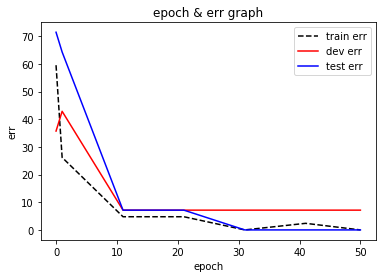

In [29]:
# epoch-err curve 
if (to_train):
    plt.plot(x_epoch, y_train_err, color='black', label='train err', linestyle='--')
    plt.plot(x_epoch, y_dev_err, color='red', label='dev err')
    plt.plot(x_epoch, y_test_err, color='blue', label='test err')
    
    plt.xlabel('epoch')
    plt.ylabel('err')
    plt.title('epoch & err graph')
    plt.legend(loc="upper right")
    plt.show()

## 6. Evaluation for dev & test data

Normalized confusion matrix


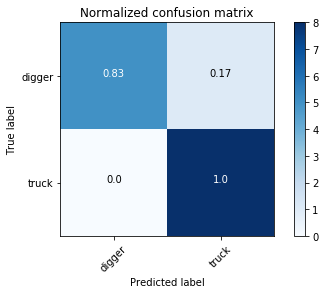

Confusion matrix, without normalization


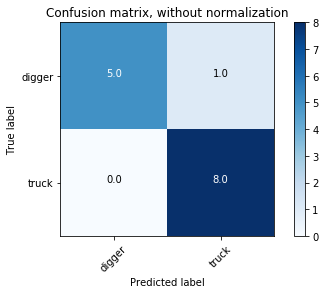

	 acc  |	 pre  |	 rec  |	 f1
 digger: 0.93 |	 1.00 |	 0.83 |	 0.91
 truck: 0.93 |	 0.89 |	 1.00 |	 0.94
*accuracy: 0.93, precision: 0.94, recall: 0.92, *f1 score: 0.93
[AP] digger: 1.00 truck: 1.00 
[mAP] 1.000
[miAP] 0.964


(array([0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([0.99675548, 0.62523586, 0.95026499, 0.99938405, 0.99566513,
        0.8636111 , 0.999219  , 0.99936277, 0.99615747, 0.97470385,
        0.99647474, 0.99907207, 0.98459947, 0.97946602]))

In [30]:
model.eval()   # evaluation(test) mode 로 바꾸기 -> dropout, batch normalization 에 영향을 줌.
EvaluateClassifier(dev_batch, model, dev_data.classes, batch_size)

Normalized confusion matrix


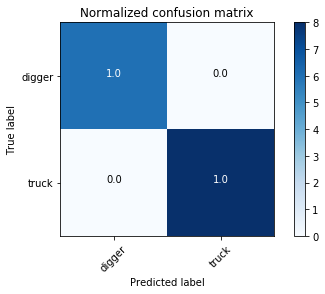

Confusion matrix, without normalization


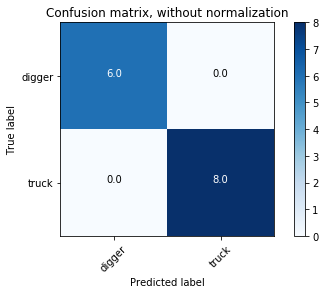

	 acc  |	 pre  |	 rec  |	 f1
 digger: 1.00 |	 1.00 |	 1.00 |	 1.00
 truck: 1.00 |	 1.00 |	 1.00 |	 1.00
*accuracy: 1.00, precision: 1.00, recall: 1.00, *f1 score: 1.00
[AP] digger: 1.00 truck: 1.00 
[mAP] 1.000
[miAP] 1.000


In [31]:
model.eval()
_, _,_ = EvaluateClassifier(test_batch, model, test_data.classes, batch_size)

Category: digger
 True predicted images/total digger category: 6 / 6
Predicted probability: [0.9906941 0.0093059]


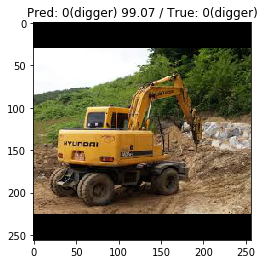

Predicted probability: [0.9733761  0.02662388]


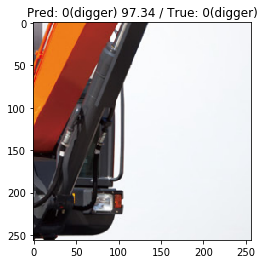

 False predicted images/total digger category: 0 / 6
Category: truck
 True predicted images/total truck category: 8 / 8
Predicted probability: [0.00165861 0.9983414 ]


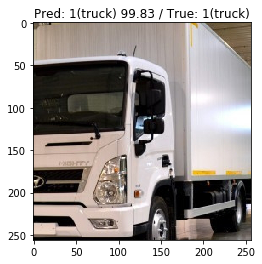

Predicted probability: [0.03733275 0.9626672 ]


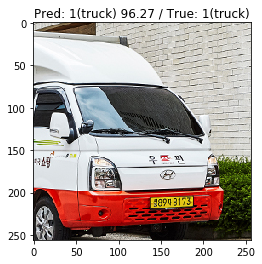

 False predicted images/total truck category: 0 / 8


In [32]:
VisTFPred(test_batch, model, test_data.classes, batch_size, i_n=2)